In [11]:
from datetime import datetime
import itertools
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from database import data_utils, data_loader
from models import basic_nn

import importlib
importlib.reload(basic_nn)
importlib.reload(data_loader)

<module 'database.data_loader' from '/Users/zack/Desktop/valle/src/database/data_loader.py'>

In [12]:
# Read in config
with open("../results/kcm2weeks/data/config.json", "r") as f:
    kcm_config = json.load(f)
# Read in train data
kcm_data_train = []
for i in range(0,5):
    kcm_contents = open("../results/kcm2weeks/data/train_0"+str(i), "r").read()
    kcm_data_train.append([json.loads(str(item)) for item in kcm_contents.strip().split('\n')])
kcm_data_train = list(itertools.chain.from_iterable(kcm_data_train))
# Read in test data
kcm_contents = open("../results/kcm2weeks/data/test", "r").read()
kcm_data_valid = [json.loads(str(item)) for item in kcm_contents.strip().split('\n')]

In [16]:
# Set hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
LEARN_RATE = 1e-3
HIDDEN_SIZE = 512

# Use acceleration if available
device = torch.device("cpu")

# Make data loaders
dataloader_train = data_loader.make_dataloader(kcm_data_train, kcm_config, BATCH_SIZE, device)
dataloader_valid = data_loader.make_dataloader(kcm_data_valid, kcm_config, BATCH_SIZE, device)

# Initialize model
# KCM: 1147
# NWY: 646
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 8,
        'col': 4
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4,
        'col': 5
    }
}
model = basic_nn.BasicNeuralNet(dataloader_train.dataset[0][0].shape[0], embed_dict, HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
loss_fn = torch.nn.MSELoss()

print(f"Using device: {device}")
print(f"Model: {model}")

Using device: cpu
Model: BasicNeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (embeddingTimeID): Embedding(1440, 8)
  (embeddingWeekID): Embedding(7, 4)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [17]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_vloss = 100000000.

training_loss = []
validation_loss = []
training_steps = len(dataloader_train)
validation_steps = len(dataloader_valid)

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch_number}')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_tloss = 0.0
    last_loss = 0.0

    # Iterate over all batches per-epoch
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Run forward/backward
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()

        # Adjust weights
        optimizer.step()

        # Gather data and report
        running_tloss += loss.item()

    # We don't need gradients on to do reporting
    model.train(False)

    avg_batch_loss = running_tloss / training_steps
    training_loss.append(avg_batch_loss)

    running_vloss = 0.0
    for i, vdata in enumerate(dataloader_valid):
        vinputs, vlabels = vdata
        vpreds = model(vinputs)
        vloss = loss_fn(vpreds, vlabels)
        running_vloss += vloss
    avg_valid_loss = running_vloss / validation_steps
    validation_loss.append(avg_valid_loss.item())

    print(f'LOSS: train {avg_batch_loss} valid {avg_valid_loss}')

    # Track best performance, and save the model's state
    if avg_valid_loss < best_vloss:
        best_vloss = avg_valid_loss
        model_path = f'../results/basic_nn/model_{timestamp}_{epoch_number}'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH: 0
LOSS: train 263.32557884852093 valid 181.92849731445312
EPOCH: 1
LOSS: train 147.00268218252393 valid 147.82725524902344
EPOCH: 2
LOSS: train 131.33994017706976 valid 141.46243286132812
EPOCH: 3
LOSS: train 122.18213166130914 valid 127.55902862548828
EPOCH: 4
LOSS: train 114.04471797413296 valid 125.38867950439453
EPOCH: 5
LOSS: train 107.89013001653883 valid 115.16986083984375
EPOCH: 6
LOSS: train 102.55093924204509 valid 109.39103698730469
EPOCH: 7
LOSS: train 97.92731761932373 valid 105.37925720214844
EPOCH: 8
LOSS: train 94.05638762315114 valid 108.03231811523438
EPOCH: 9
LOSS: train 90.8570900493198 valid 98.21656799316406
EPOCH: 10
LOSS: train 87.94320374064975 valid 96.15100860595703
EPOCH: 11
LOSS: train 85.08896169397566 valid 93.95860290527344
EPOCH: 12
LOSS: train 82.8402642276552 valid 92.6119155883789
EPOCH: 13
LOSS: train 81.24977046913571 valid 92.723876953125
EPOCH: 14
LOSS: train 79.14654905266232 valid 92.69767761230469
EPOCH: 15
LOSS: train 77.44256393114726

<AxesSubplot: xlabel='Epoch', ylabel='value'>

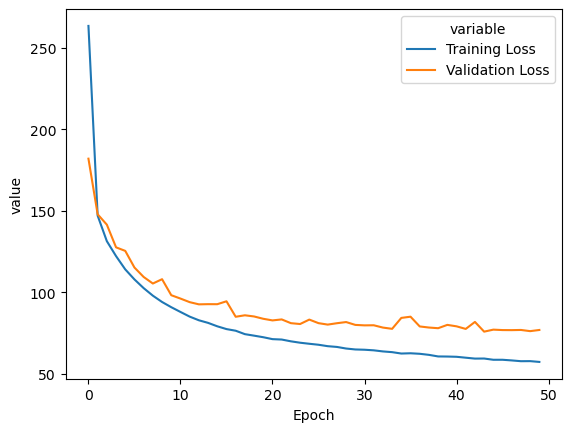

In [18]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(training_loss))],
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }
)

sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))